### understanding the nature of the dataset

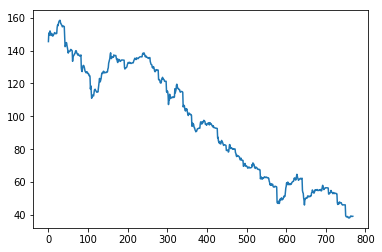

In [2]:
import pandas
import matplotlib.pyplot as plt

# 1st column of csv file is "date" which we don't need. And 3 footer lines can also be skipped.
dataset = pandas.read_csv('iron_price.csv', usecols=[1], engine='python', skipfooter=3)

plt.plot(dataset)
plt.show()

### LSTM Network for Regression
We can phrase the problem as a regression problem.

That is, given the price this day, what will be the price of next dat projected sequentially to bigger time periods

We can write a simple function to convert our single column of data into a two-column dataset: the first column containing this days's (t) price and the second column containing next day's (t+1) price, to be predicted.
Hence previous prices can be used as features for the prediction of the next price

In [3]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Before proceeding, it is a good idea to fix the random number seed to ensure our results are reproducible.

In [6]:
# fix random seed for reproducibility
seed = np.random.seed(7)

We can also use the code from the previous section to load the dataset as a Pandas dataframe. We can then extract the NumPy array from the dataframe and convert the integer values to floating point values, which are more suitable for modeling with a neural network.

In [7]:
# load the dataset
filename = 'iron_price.csv'
#filename = 'international-airline-passengers.csv'
skipfooter = 2
dataframe = pandas.read_csv(filename, usecols=[1], engine='python', skipfooter=skipfooter)
dataset = dataframe.values
dataset = dataset.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [8]:
# normalize the dataset
data_range = (-1, 1)
scaler = MinMaxScaler(feature_range=data_range)        
# scaler can also de-normalize the dataset by scaler.inverse_transform(), useful for actual prediction
dataset_scaled = scaler.fit_transform(dataset)
#dataset_scaled = numpy.array(dataset_scaled)

In [9]:
print(dataset_scaled.shape)
print(len(dataset_scaled))
print(dataset_scaled[0:10])

(770, 1)
770
[[0.78396344]
 [0.8712089 ]
 [0.8628998 ]
 [0.8504362 ]
 [0.89198184]
 [0.8775239 ]
 [0.8597424 ]
 [0.84628177]
 [0.8660574 ]
 [0.86157036]]


In [10]:
# split into train and test sets (traing:test  = 70:30) 
train_size = int(len(dataset_scaled) * 0.70)
test_size = len(dataset_scaled) - train_size
train, test = dataset_scaled[0:train_size,:], dataset_scaled[train_size:len(dataset),:]
print(len(train), len(test))

539 231


LSTM Data Preparation
Before we can fit an LSTM model to the dataset, we must transform the data.

This section is broken down into three steps:

Transform the time series into a supervised learning problem
Transform the time series data so that it is stationary.
Transform the observations to have a specific scale.

Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period in this case defaulted to 1

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

It can be configured, and we will by constructing a differently shaped dataset in the next section.

In [18]:
# convert an array of values into a dataset matrix
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    i_range = len(data) - look_back - 1
    print(i_range)
    for i in range(0, i_range):
        dataX.append(data[i:(i+look_back)])    # index can move down to len(dataset)-1
        dataY.append(data[i + look_back])      # Y is the item that skips look_back number of items
    
    return np.array(dataX), np.array(dataY)

In [19]:
# try it
look_back = 4
dataX, dataY = create_dataset(dataset_scaled, look_back=look_back)

765


In [20]:
print("X shape:", dataX.shape)
print("Y shape:", dataY.shape)
   
print("Xt-3     Xt-2      Xt-1      Xt        Y")
print("---------------------------------------------")
for i in range(len(dataX)): 
    print('%.2f   %.2f    %.2f    %.2f    %.2f' % (dataX[i][0][0], dataX[i][1][0], dataX[i][2][0], dataX[i][3][0], dataY[i][0]))


X shape: (765, 4, 1)
Y shape: (765, 1)
Xt-3     Xt-2      Xt-1      Xt        Y
---------------------------------------------
0.78   0.87    0.86    0.85    0.89
0.87   0.86    0.85    0.89    0.88
0.86   0.85    0.89    0.88    0.86
0.85   0.89    0.88    0.86    0.85
0.89   0.88    0.86    0.85    0.87
0.88   0.86    0.85    0.87    0.86
0.86   0.85    0.87    0.86    0.84
0.85   0.87    0.86    0.84    0.84
0.87   0.86    0.84    0.84    0.85
0.86   0.84    0.84    0.85    0.85
0.84   0.84    0.85    0.85    0.86
0.84   0.85    0.85    0.86    0.87
0.85   0.85    0.86    0.87    0.88
0.85   0.86    0.87    0.88    0.87
0.86   0.87    0.88    0.87    0.87
0.87   0.88    0.87    0.87    0.86
0.88   0.87    0.87    0.86    0.87
0.87   0.87    0.86    0.87    0.87
0.87   0.86    0.87    0.87    0.93
0.86   0.87    0.87    0.93    0.95
0.87   0.87    0.93    0.95    0.94
0.87   0.93    0.95    0.94    0.96
0.93   0.95    0.94    0.96    0.98
0.95   0.94    0.96    0.98    0.99
0.94   0.9

In [21]:
# Reshape to (samples, timestep, features)
dataX = np.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))

print("X shape:", dataX.shape)

X shape: (765, 1, 4)


### Let's use this function to prepare the train and test datasets for modeling.

In [22]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)      # trainX is input, trainY is expected output
testX, testY = create_dataset(test, look_back)

537
229


The LSTM network expects the input data (X) to be provided with a specific array structure in the form of 3D: [samples, time steps, features], or in other words, 3D tensor with shape (batch_size, timesteps, input_dim), or optionally, 2D tensors with shape (batch_size, output_dim).

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure 

In [23]:
# reshape input to be [samples, time steps, features]
print("Original trainX shape:", trainX.shape)
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[1]))     
# timestep = 1, input_dim = trainX.shape[1]

testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[1]))
print("New trainX shape:", trainX.shape)
print("trainY shape:", trainY.shape)
print("trainY example:", trainY[0])

Original trainX shape: (537, 1, 1)
New trainX shape: (537, 1, 1)
trainY shape: (537, 1)
trainY example: [0.8712089]


We are now ready to design and fit our LSTM network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 50 epochs and a batch size of 1 is used.

In [25]:
# create and fit the LSTM network
from keras.layers import Dropout

batch_size = 1
timesteps = trainX.shape[1]
input_dim = trainX.shape[2]

model = Sequential()
#model.add(LSTM(8, input_shape=(1, look_back)))    # 4 or 8 is the number of LSTM units or dimensions of output of LSTM layer, can be any integer. input_shape must show up in the first layer
model.add(LSTM(4, batch_input_shape=(batch_size, timesteps, input_dim)))
model.add(Dense(10))    # not necessary, but just want to try it
#model.add(Dropout(0.8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)  

Epoch 1/100
 - 2s - loss: 0.0355
Epoch 2/100
 - 1s - loss: 8.0472e-04
Epoch 3/100
 - 1s - loss: 7.6498e-04
Epoch 4/100
 - 1s - loss: 7.7992e-04
Epoch 5/100
 - 1s - loss: 7.7949e-04
Epoch 6/100
 - 1s - loss: 7.4658e-04
Epoch 7/100
 - 1s - loss: 7.6189e-04
Epoch 8/100
 - 1s - loss: 7.9662e-04
Epoch 9/100
 - 1s - loss: 7.9222e-04
Epoch 10/100
 - 1s - loss: 8.1983e-04
Epoch 11/100
 - 1s - loss: 7.7168e-04
Epoch 12/100
 - 1s - loss: 7.3971e-04
Epoch 13/100
 - 1s - loss: 7.6046e-04
Epoch 14/100
 - 1s - loss: 7.9568e-04
Epoch 15/100
 - 1s - loss: 7.6956e-04
Epoch 16/100
 - 1s - loss: 7.3856e-04
Epoch 17/100
 - 1s - loss: 7.6049e-04
Epoch 18/100
 - 1s - loss: 7.5421e-04
Epoch 19/100
 - 1s - loss: 7.4675e-04
Epoch 20/100
 - 1s - loss: 7.3400e-04
Epoch 21/100
 - 1s - loss: 7.1255e-04
Epoch 22/100
 - 1s - loss: 7.4391e-04
Epoch 23/100
 - 1s - loss: 7.1698e-04
Epoch 24/100
 - 1s - loss: 7.9294e-04
Epoch 25/100
 - 1s - loss: 6.8144e-04
Epoch 26/100
 - 1s - loss: 7.9897e-04
Epoch 27/100
 - 1s - loss

### it turns out that epochs = 25 is enough, 100 is not necessary 

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data

In [26]:
# make predictions
trainPredict = model.predict(trainX, batch_size)
testPredict = model.predict(testX, batch_size)

In [27]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)  
# trainY is of shape (samples, features) while trainX is of (samples, timesteps, features) )

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [28]:
print("trainY shape:", trainY.shape)
print("trainPredict shape:", trainPredict.shape)
print("testY shape:", testY.shape)
print("testPredict shape:", testPredict.shape)

trainY shape: (537, 1)
trainPredict shape: (537, 1)
testY shape: (229, 1)
testPredict shape: (229, 1)


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset (because the output Y is 1 timestep shift from input X). Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

In [31]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
#print(trainPredictPlot[0])
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

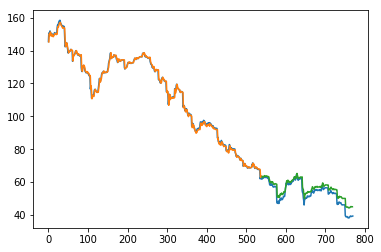

In [32]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset_scaled))
#plt.plot(dataset_scaled)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [33]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_3 (Dense)              (1, 10)                   50        
_________________________________________________________________
dense_4 (Dense)              (1, 1)                    11        
Total params: 157
Trainable params: 157
Non-trainable params: 0
_________________________________________________________________
None
